In [4]:
import time
from math import *
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly

In [5]:
data = np.loadtxt('ACH.dat')

In [6]:
Lbox = 1100
hLbox = Lbox/2

Nt = 110000
nbar = Nt / Lbox**3

nk = 5
fbasis = np.zeros(nk+1)

nr = 21
rmin = 60
rmax = 120
rmid = (rmax+rmin)/2
mu = rmid
scale = 4.6

In [7]:
sample = np.random.choice(len(data),size=Nt,replace=False)

In [8]:
x, y, z = data[sample].T

In [9]:
t0 = time.time()

Nb = np.zeros(nr)

for i in range(0,Nt-1):
    j = np.arange(i+1,Nt)
    
    dx = x[i] - x[j]
    dy = y[i] - y[j]
    dz = z[i] - z[j]
        
    ### periodic boundary conditions on separations: 
    dx[np.where(dx>hLbox)] -= Lbox
    dy[np.where(dy>hLbox)] -= Lbox
    dz[np.where(dz>hLbox)] -= Lbox
    dx[np.where(dx<-hLbox)] += Lbox
    dy[np.where(dy<-hLbox)] += Lbox
    dz[np.where(dz<-hLbox)] += Lbox

    r2 = dx**2 + dy**2 + dz**2
    r = np.sqrt(r2)
    
    ### bin pair counts:
    hi, bins = np.histogram(r, bins=nr, range=(rmin,rmax))
    Nb += hi
    
    ### polynomial pair counts:
    r = r[(r>=rmin) & (r<=rmax)]
    if len(r) > 0:
        yokr = (r - mu) / scale
        for k in range(0,nk+1):
            fbasis[k] += sum(yokr**k) / Nt
            

fbasis = fbasis*2 / (Nt-1)
    

t1 = time.time() 
print('Time =', t1-t0)

Time = 534.9195442199707


In [10]:
DD = 2*Nb

dr = bins[1] - bins[0]
rbin = (bins[1:] + bins[:-1])/2

RR = (Nt-1)*nbar*4*pi/3*(bins[1:]**3-bins[:-1]**3)
        
Xi12 = DD/RR - 1  

sqrtN = np.sqrt(2*Nb)
errxi = sqrtN/RR

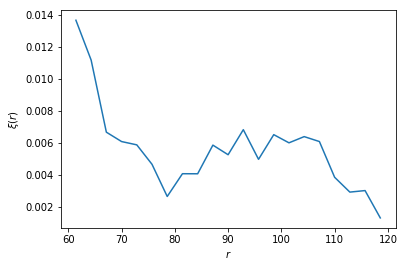

In [11]:
### plot binned xi:
plt.plot(rbin,Xi12)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.show()

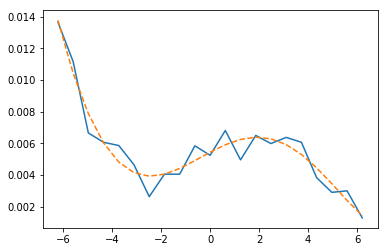

In [12]:
### check if a polynomial is an ok fit to it:
xbin = (rbin - mu)/scale
aFit = np.polyfit(xbin, Xi12, nk)
p = np.poly1d(aFit)
plt.plot(xbin,Xi12, xbin, p(xbin), '--')
plt.show()

In [24]:
### analyticRR:

### setting up the vector of RR:
umax = (rmax - mu)/scale
umin = (rmin - mu)/scale
vmax = (rmax - mu)/Lbox
vmin = (rmin - mu)/Lbox

V = np.zeros(2*nk + 2)
for k in range(0, len(V)):
    umaxk = umax**k
    umink = umin**k
    Va = (vmax**3 * umaxk - vmin**3 * umink) / (k+3)
    Vb = 2 * (mu/Lbox) * (vmax**2 * umaxk - vmin**2 * umink) / (k+2)
    Vc = (mu/Lbox)**2 * (vmax*umaxk - vmin*umink) / (k+1)
    V[k] = Va + Vb + Vc
nuRR = 4 * pi * V[0:nk+1] 

### the corresponding F_RR:
dim = (nk+1, nk+1)
FRR = np.zeros(dim)
for k in range(0,nk+1):
    for l in range(0,nk+1):
        FRR[k,l] = 4*pi*V[k+l]
        
invF = np.linalg.inv(FRR)

In [25]:
### check if polynomial works in theory:
nuDD = fbasis
theoryDiff = np.zeros(nk+1)
theoryDiff = np.dot(FRR, aFit)

### check that procedure returns the same ak:
aTheory = np.dot(invF, theoryDiff)
print ('Theory:', aTheory) 

Theory: [  3.16681138e-07   3.38985973e-06  -5.95059250e-05  -7.45533504e-05
   8.30306996e-04   5.44146914e-03]


In [38]:
### do the same for simulation basis:
simDiff = nuDD - nuRR
aSim = np.dot(invF, simDiff)
print ('Sim:', aSim)

checkDiff = 0*simDiff
checkDiff = np.dot(FRR, aSim)

Sim: [  5.51233874e-03   8.28431458e-04  -8.96440063e-05  -5.85245694e-05
   3.78091776e-06   2.88946154e-07]


In [39]:
### show the polynomial fit:
rtable = np.arange(60,121)
xiSim = 0*rtable
xiFit = 0*rtable
xiTheory = 0*rtable
ytable = (rtable-mu)/scale
for k in range(0,nk+1):
    xiSim = xiSim + aSim[k] * ytable**k
    xiFit = xiFit + aFit[k] * ytable**k

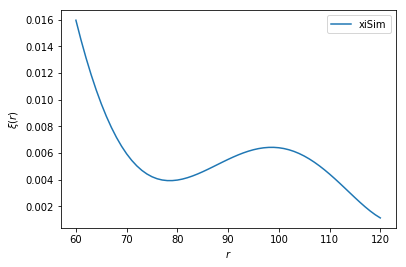

In [40]:
### plot xi:
plt.plot(rtable,xiSim)
#plt.plot(rtable,xiFit)
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend(["xiSim", "xiFit"])
plt.show()